In [2]:
from constants import *
from data.load_data import load_arff_file_from_file_path
from clustering_algorithms.kmeans import calculate_wcss
from main import plot_clusters as plot_clustering

# We want to just test the clustering on a single dataset
# Choose the diamond9 dataset

def test_clustering(
    dataset_name,
    clustering_algorithm,
    approximate_adder_name,
    n_clusters,
    bit_configuration = (32, 8),
    initialisation_random_state = 42,
    maximum_iterations = 20,
    plot_clusters = False
):
    # We first load the dataset
    dataset = load_arff_file_from_file_path(DATASETS[dataset_name]['path'])
    
    # We then load the clustering algorithm
    clustering_function = CLUSTERING_ALGORITHMS[clustering_algorithm]['algorithm']
    # The clustering function has parameters (X, k, max_iters=100,  random_state=26, adder=accurate_adder, bits=(32, 4))
    # We then load the approximate adder
    adder = APPROXIMATE_ADDERS[approximate_adder_name]['adder']
    # The adder has parameters (num1, num2, total_bits, inaccurate_bits)
       
    # We then initialize the results dictionary
    
    clusters, centroids, converged = clustering_function(dataset, n_clusters, max_iters=maximum_iterations, adder=adder, random_state=initialisation_random_state, bits=bit_configuration)
    WCSS = calculate_wcss(dataset, clusters, centroids)
    
    if plot_clusters:
        plot_clustering(dataset, clusters, centroids)
    
    return WCSS, converged

(12001.033925446984, True)

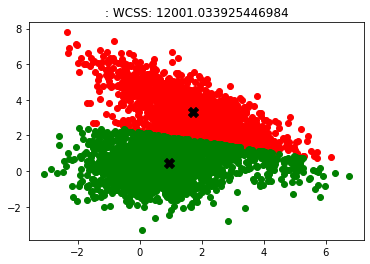

In [3]:
test_clustering('engytime', 'KMeans++_with_adder_mod', 'accurate_adder', 2, bit_configuration=(16,5),initialisation_random_state=42, plot_clusters=True)
test_clustering('engytime', 'KMeans++_with_adder_mod', 'BPAA2_LSP1', 2, bit_configuration=(16,5),initialisation_random_state=42, plot_clusters=True)


In [4]:
clustering_function = CLUSTERING_ALGORITHMS["KMeans++_with_adder_mod"]['algorithm']

In [5]:
import numpy as np

def compare_clusters(clusters_A, clusters_B):
    """
    Compare clusters_A and clusters_B and compute set differences for the most similar centroids.
    
    Parameters:
        clusters_A (dict): Dictionary with centroids (tuple) as keys and cluster points (arrays) as values.
        clusters_B (dict): Dictionary with centroids (tuple) as keys and cluster points (arrays) as values.
        
    Returns:
        dict: A new dictionary where keys are concatenated tuples of centroids (from A and B) 
              and values are arrays of set differences between the corresponding clusters.
    """
    clusters_difference = {}

    # Iterate over centroids in clusters_A
    for centroid_A, points_A in clusters_A.items():
        # Find the most similar centroid in clusters_B
        most_similar_centroid_B = None
        min_distance = float('inf')

        for centroid_B in clusters_B.keys():
            # Compute similarity (here, Euclidean distance)
            distance = np.linalg.norm(np.array(centroid_A) - np.array(centroid_B))
            if distance < min_distance:
                min_distance = distance
                most_similar_centroid_B = centroid_B

        # Perform set difference between the clusters
        points_B = clusters_B[most_similar_centroid_B]
        set_diff = np.setdiff1d(points_A, points_B)

        # Add the result to the dictionary
        key = (tuple(centroid_A), tuple(most_similar_centroid_B))
        clusters_difference[key] = set_diff

    return clusters_difference



Number of clusters for diamond9: 9
(-0.9890573519519522, 1.9895816216216204) vs (-0.9890573519519522, 1.9895816216216204)
(2.9942383183183185, 1.9957450750750751) vs (2.9942383183183185, 1.9957450750750751)
(-0.9759469892215572, 0.008352952182634727) vs (-0.9759469892215572, 0.008352952182634727)
(0.9900418529940125, 3.9752097604790437) vs (0.9900418529940125, 3.9752097604790437)
(0.9998776468468462, -0.03274744333633633) vs (0.9998776468468462, -0.03274744333633633)
(0.9934986583832336, 1.9987206586826336) vs (0.9934986583832336, 1.9987206586826336)
(3.009481771771773, 0.012773486066066039) vs (3.009481771771773, 0.012773486066066039)
(3.0037039339339344, 3.971588348348349) vs (3.0037039339339344, 3.971588348348349)
(-0.9929764522522526, 4.00288102102102) vs (-0.9929764522522526, 4.00288102102102)


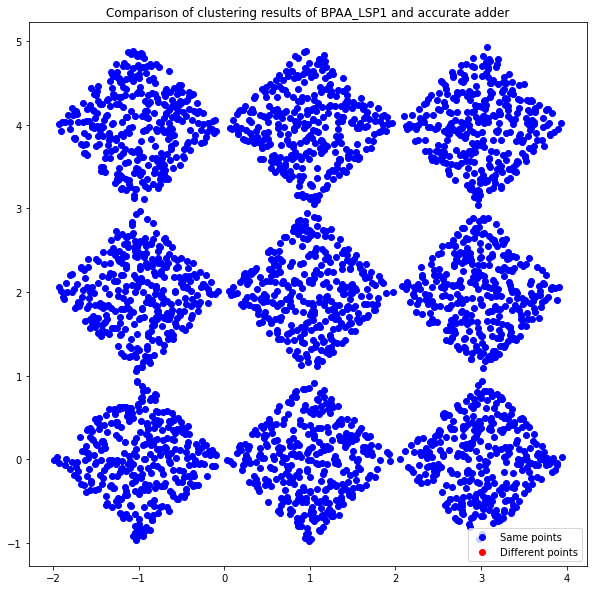

In [6]:
import matplotlib.pyplot as plt

for dataset_name in ['diamond9']:
    dataset = load_arff_file_from_file_path(DATASETS[dataset_name]['path'])
    n_clusters = DATASETS[dataset_name]['clusters']

    bit_configuration = (16, 5)

    clusters_A, centroids_A, _ = clustering_function(dataset, n_clusters, adder = APPROXIMATE_ADDERS['accurate_adder']['adder'], bits=bit_configuration)
    clusters_B, centroids_B, _ = clustering_function(dataset, n_clusters, adder = APPROXIMATE_ADDERS['BPAA2_LSP1']['adder'], bits=bit_configuration)

    wcssA = calculate_wcss(dataset, clusters_A, centroids_A)
    wcssB = calculate_wcss(dataset, clusters_B, centroids_B)
    # print(f'WCSS difference between accurate adder and BPAA2_LSP1: {wcssA - wcssB}')

    def clustering_to_dict(clusters, centroids):
        return {
            tuple(centroid): cluster for centroid, cluster in zip(centroids, clusters)
        }

    cluster_dict_A = clustering_to_dict(clusters_A, centroids_A)
    cluster_dict_B = clustering_to_dict(clusters_B, centroids_B)
    clusters_diff = compare_clusters(cluster_dict_A, cluster_dict_B)
    
    print(f"\nNumber of clusters for {dataset_name}: {n_clusters}")
    for centroids_tuple in clusters_diff.keys():
        print(f"{centroids_tuple[0]} vs {centroids_tuple[1]}")
        


    different_points_idx = [idx for cluster in clusters_diff.values() for idx in cluster]
    same_points_idx = np.setdiff1d(np.arange(len(dataset)), different_points_idx)
    same_points = dataset[same_points_idx]
    different_points = dataset[different_points_idx]

    # print(
    #     f"Number of points in different clusters for {dataset_name}: {len(different_points)}\n",
    #     different_points
    # )

# Adjust size of the plot
plt.figure(figsize=(10, 10))

# draw a scatter plot of the same and different points
plt.scatter(same_points[:,0], same_points[:,1], color='blue', label='Same points')
plt.scatter(different_points[:,0], different_points[:,1], color='red', label='Different points')
plt.legend()
plt.title('Comparison of clustering results of BPAA_LSP1 and accurate adder')
plt.show()

In [7]:
clusters_diff


{((-0.9890573519519522, 1.9895816216216204),
  (-0.9890573519519522, 1.9895816216216204)): array([], dtype=int32),
 ((2.9942383183183185, 1.9957450750750751),
  (2.9942383183183185, 1.9957450750750751)): array([], dtype=int32),
 ((-0.9759469892215572, 0.008352952182634727),
  (-0.9759469892215572, 0.008352952182634727)): array([], dtype=int32),
 ((0.9900418529940125, 3.9752097604790437),
  (0.9900418529940125, 3.9752097604790437)): array([], dtype=int32),
 ((0.9998776468468462, -0.03274744333633633),
  (0.9998776468468462, -0.03274744333633633)): array([], dtype=int32),
 ((0.9934986583832336, 1.9987206586826336),
  (0.9934986583832336, 1.9987206586826336)): array([], dtype=int32),
 ((3.009481771771773, 0.012773486066066039),
  (3.009481771771773, 0.012773486066066039)): array([], dtype=int32),
 ((3.0037039339339344, 3.971588348348349),
  (3.0037039339339344, 3.971588348348349)): array([], dtype=int32),
 ((-0.9929764522522526, 4.00288102102102),
  (-0.9929764522522526, 4.00288102102102)